In [1]:
import time
import math
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import dataset

from sklearn.metrics import confusion_matrix
from datetime import timedelta
%matplotlib inline

In [6]:
%load_ext autoreload
%autoreload 2
from model import *
from utils import *
from DataSet import *
from opt import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Reading time: 0:00:00.165009


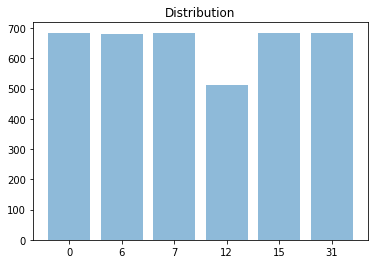

In [3]:
labels = get_labels('D:/Download/dataset/vip/zach_cont_gest_1/data.txt')
imgs, labels = get_data(labels, 'D:/Download/dataset/vip/zach_cont_gest_1/*.png')
imgs, labels = subsampling(imgs, labels)
get_distribution(labels, plot=True)
train_set = read_data_sets(imgs, labels).train
val_set = read_data_sets(imgs, labels).validation
test_set = read_data_sets(imgs, labels).test

In [4]:
num_channels = 1
img_size = 128
img_size_flat = img_size * img_size * num_channels
img_shape = (img_size, img_size)
classes = np.array(list(set(labels)))
num_classes = len(classes)
batch_size = 32
epoch_size = train_set.num_examples//32

In [7]:
with tf.Graph().as_default():
    weights = {
        'wc1':weight_variable([5, 5, 1, 32]),
        'wc2':weight_variable([5, 5, 32, 64]),
        'wfc1':weight_variable([65536, 1024]),
        'wfc2':weight_variable([1024, num_classes]),
    }

    biases = {
        'bc1':bias_variable([32]),
        'bc2':bias_variable([64]),
        'bfc1':bias_variable([1024]),
        'bfc2':bias_variable([num_classes])
    }
    x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
    y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
    logits = conv_net(x, weights, biases, img_size, num_channels)
    loss_op = loss_(logits, y_true)
    train_op = minimize_(loss_op, 1e-4)
    accuracy = evaluate_(logits, y_true)
    summary_op = tf.summary.merge_all()
    saver = tf.train.Saver()
    sess = tf.Session()
    init = tf.global_variables_initializer()
    sess.run(init)
    summary_writer = tf.summary.FileWriter(logdir='log/')
    import time
    step_log = open('step_log.txt', 'w') 
    eval_log = open('eval_log.txt', 'w')
    epoch = 1
    for step in range(1, 11):
        start_time = time.time()
        x_batch, cls_batch, y_true_batch = train_set.next_batch(batch_size)  
        x_batch = x_batch.reshape(batch_size, img_size_flat)
        feed_dict_train = {x: x_batch, y_true: y_true_batch}
        _, loss_value = sess.run([train_op, loss_op], feed_dict=feed_dict_train)

        duration = time.time() - start_time
        if step % 50 == 0:
            log = ('Step %d: loss = %.2f (%.3f sec)\n' % (step, loss_value, duration))
            step_log.write(log)
            summary_str = sess.run(summary_op, feed_dict=feed_dict_train)
            summary_writer.add_summary(summary_str, step)

        if step % epoch_size == 0:
            saver.save(sess, 'log/', global_step=step)
            eval_log.write('-------------------------Epoch '+str(epoch)+'-----------------------:\n')
            eval_log.write('Training Data Eval:\n')
            start_time = time.time()
            _eval(sess, accuracy, x, y_true, train_set, eval_log)
            eval_log.write('Training Duration: %.3f sec' % (time.time() - start_time))

            eval_log.write('Validation Data Eval:\n')
            start_time = time.time()
            _eval(sess, accuracy, x, y_true, val_set, eval_log)
            eval_log.write('Validation Duration: %.3f sec' % (time.time() - start_time))

            eval_log.write('Testing Data Eval:\n')
            start_time = time.time()
            _eval(sess, accuracy, x, y_true, test_set, eval_log)
            eval_log.write('Testing Duration: %.3f sec\n' % (time.time() - start_time))
            epoch+=1
    eval_log.close()
    step_log.close()

NameError: name 'tf' is not defined

In [ ]:
plot_conv_weights(sess, weights=weights['wc1'])

In [ ]:
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])
conv1 = conv2d_layer(x_image, weights['wc1'], biases['bc1'], tf.nn.relu)
conv1 = maxpool2d_layer(conv1, strides1=2, strides2=2)
image1 = test_set.images[0]
plot_conv_layer(sess, x, layer=conv1, image=image1)